# Latent components

Latent components are model components which only activate in conjunction with other components. They can only be detected by identifying differences in attribution scores between activation patching from clean to corrupt, and activation patching from corrupt to clean.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device

from attribution_methods import integrated_gradients, activation_patching, highlight_components
from testing import Task, TaskDataset, logit_diff_metric, average_correlation, measure_overlap, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Approximating activation patching

Hypothesis: integrated gradients can approximate activation patching in either direction.

To evaluate this hypothesis, we use 100 samples from the IOI dataset and run:

- Activation patching from clean to corrupt
- Activation patching from corrupt to clean
- Integrated gradients with corrupt input and clean baseline
- Integrated gradients with clean input and corrupt baseline

We then compare the resulting attribution scores from the four runs.

### Experiment

In [4]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507,  0.1791,  4.2971,  2.9955, -0.7016, -2.1907, -3.5684,
        -4.4879, -1.2934, -3.8906, -0.6969, -0.8222,  0.0708,  0.2167,  4.4769,
         1.0375, -1.2644,  0.9309,  2.8114,  0.9975,  2.4103,  2.6244,  0.0125,
        -0.8472, -0.6130, -1.1623, -0.5109,  3.0073,  0.6154, -1.1229,  0.2680,
        -2.7379,  5.2855,  2.5019,  0.3219, -1.3112,  1.2942, -2.1428,  3.1053,
         1.6090,  3.1023,  1.8912,  0.4089,  4.0511,  2.5005,  3.5176, -1.5472,
         2.2213, -0.8523,  0.6682,  0.4244,  0.8053,  3.2905,  0.7295,  0.9946,
        -3.6073, -2.2671,  1.7894, -0.6390,  0.6320, -1.5326,  1.3206, -0.1224,
         0.1692,  1.9326,  3.1771,  1.1320, -0.0876,  3.1172,  2.3856,  3.2836,
        -2.0859,  3.6953,  2.8493, -2.4261,  1.1299,  0.1732, -1.4748, -2.1046,
        -0.6516, -0.6167,  0.0277, -1.7128,  0.6374,  2.6353, -1.4080,  3.2583,
         0.6919,

In [ ]:
ig_clean_corrupt_mlp, ig_clean_corrupt_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(ig_clean_corrupt_mlp, "results/latent_components/ioi/ig_clean_corrupt_mlp.pt")
torch.save(ig_clean_corrupt_attn, "results/latent_components/ioi/ig_clean_corrupt_attn.pt")

In [ ]:
ap_clean_corrupt_mlp, ap_clean_corrupt_attn = activation_patching(model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(ap_clean_corrupt_mlp, "results/latent_components/ioi/ap_clean_corrupt_mlp.pt")
torch.save(ap_clean_corrupt_attn, "results/latent_components/ioi/ap_clean_corrupt_attn.pt")

In [ ]:
ig_corrupt_clean_mlp, ig_corrupt_clean_attn = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, logit_diff_metric, labels)

torch.save(ig_corrupt_clean_mlp, "results/latent_components/ioi/ig_corrupt_clean_mlp.pt")
torch.save(ig_corrupt_clean_attn, "results/latent_components/ioi/ig_corrupt_clean_attn.pt")

In [ ]:
ap_corrupt_clean_mlp, ap_corrupt_clean_attn = activation_patching(model, corrupted_tokens, corrupted_cache, corrupted_logit_diff, clean_cache, clean_logit_diff, logit_diff_metric, labels)

torch.save(ap_corrupt_clean_mlp, "results/latent_components/ioi/ap_corrupt_clean_mlp.pt")
torch.save(ap_corrupt_clean_attn, "results/latent_components/ioi/ap_corrupt_clean_attn.pt")

### Analysis

We first visualise ten results from each of the four runs. We then calculate the average correlation coefficient across all 100 samples.

In [5]:
ig_corrupt_clean_mlp = torch.load("results/latent_components/ioi/ig_corrupt_clean_mlp.pt")
ap_corrupt_clean_mlp = torch.load("results/latent_components/ioi/ap_corrupt_clean_mlp.pt")

ig_corrupt_clean_attn = torch.load("results/latent_components/ioi/ig_corrupt_clean_attn.pt")
ap_corrupt_clean_attn = torch.load("results/latent_components/ioi/ap_corrupt_clean_attn.pt")

ig_clean_corrupt_mlp = torch.load("results/latent_components/ioi/ig_clean_corrupt_mlp.pt")
ap_clean_corrupt_mlp = torch.load("results/latent_components/ioi/ap_clean_corrupt_mlp.pt")

ig_clean_corrupt_attn = torch.load("results/latent_components/ioi/ig_clean_corrupt_attn.pt")
ap_clean_corrupt_attn = torch.load("results/latent_components/ioi/ap_clean_corrupt_attn.pt")

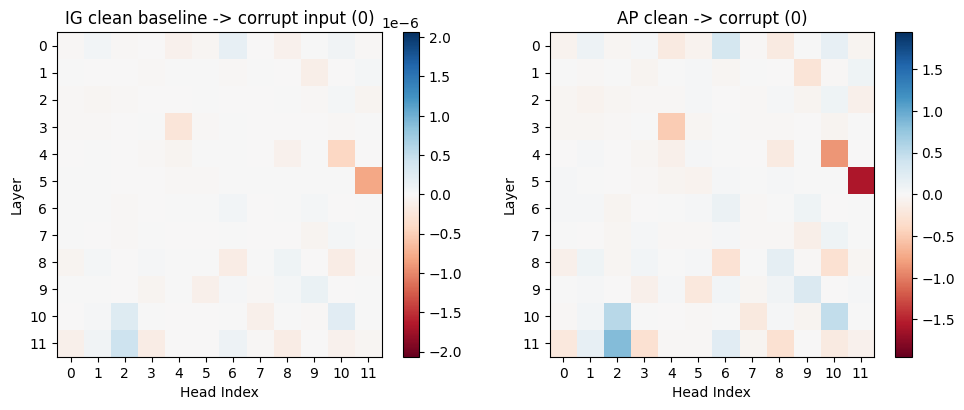

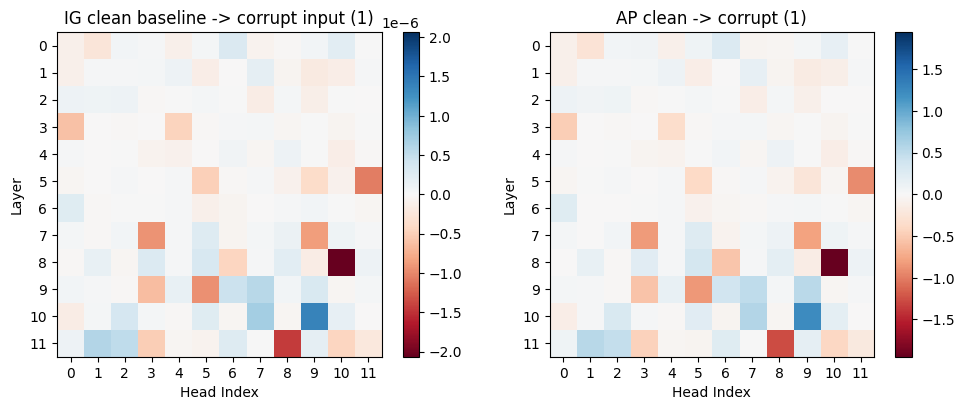

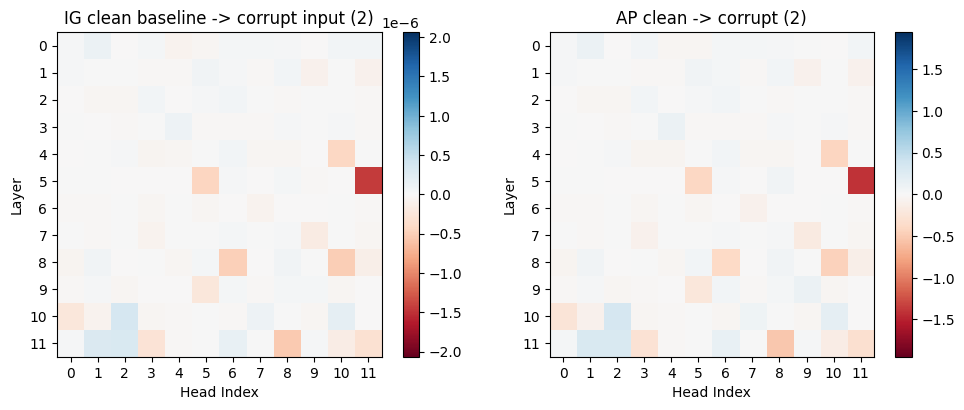

In [8]:
plot_attn_comparison(ig_clean_corrupt_attn[:3], ap_clean_corrupt_attn[:3], model, "IG clean baseline -> corrupt input", "AP clean -> corrupt")

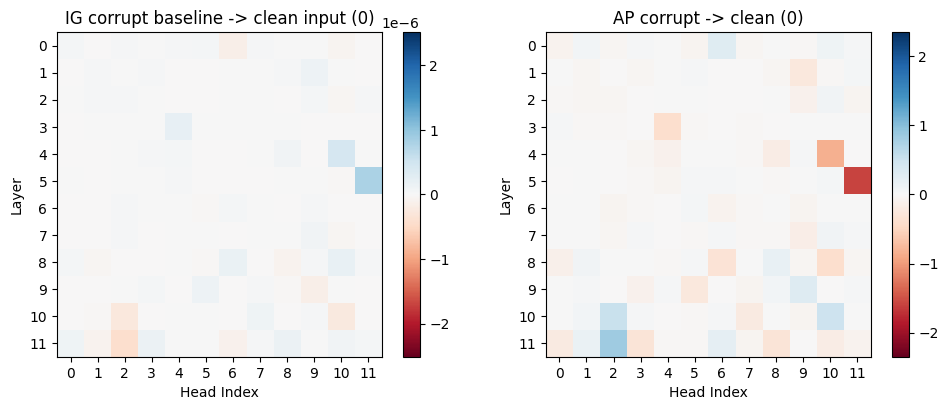

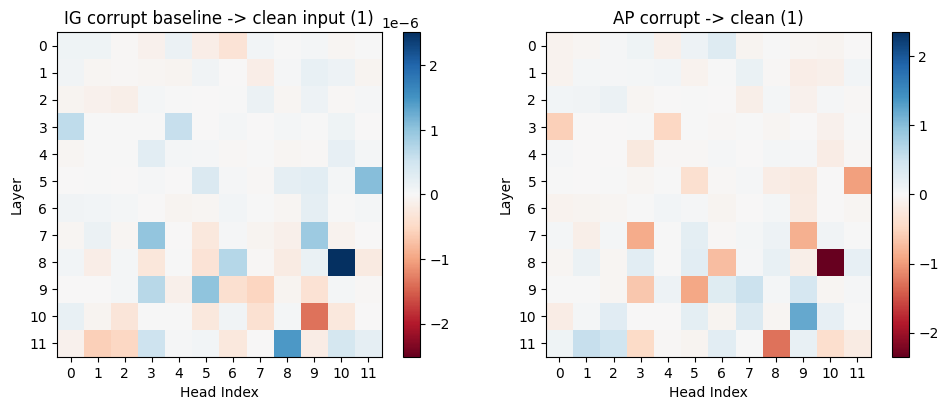

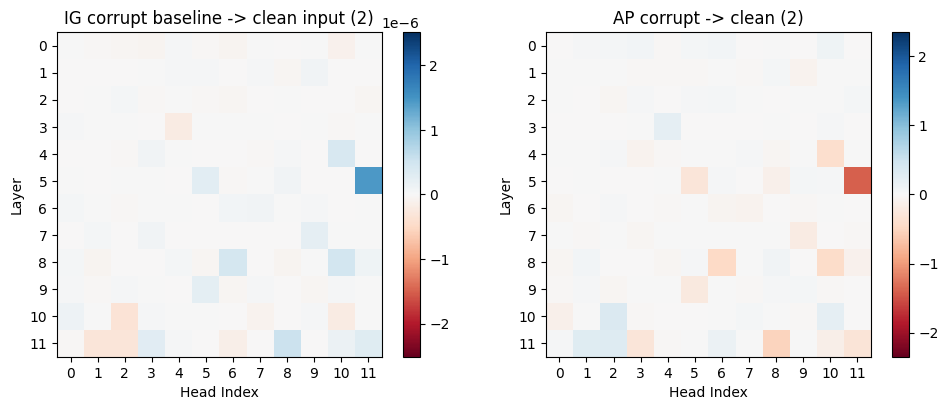

In [9]:
plot_attn_comparison(ig_corrupt_clean_attn[:3], ap_corrupt_clean_attn[:3], model, "IG corrupt baseline -> clean input", "AP corrupt -> clean")

Correlation between clean -> corrupt IG and AP


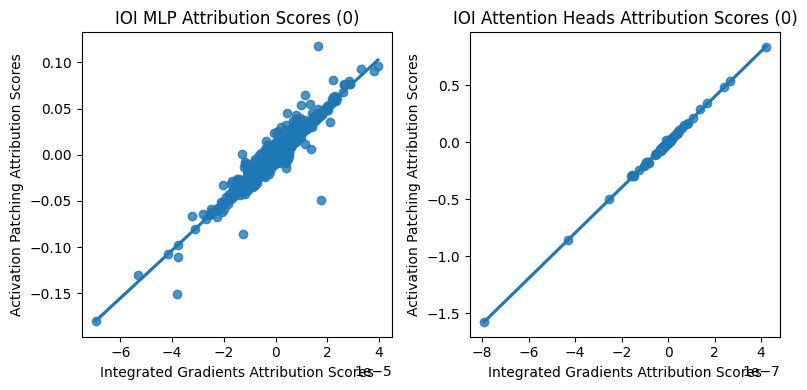

Correlation coefficient for neurons: 0.9781080393095625
Correlation coefficient for attention heads: 0.9996766519539676


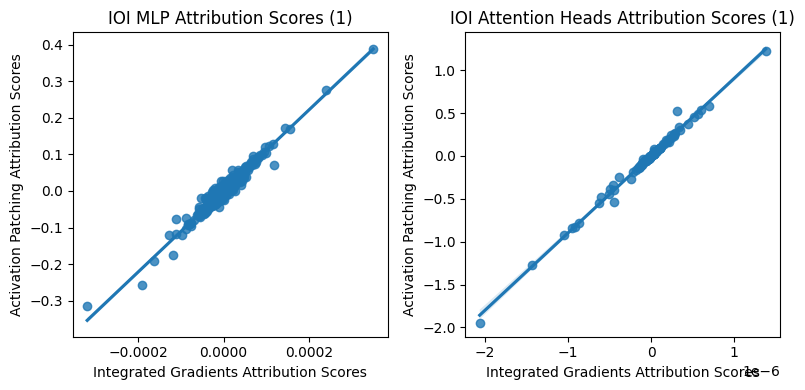

Correlation coefficient for neurons: 0.9806869207736839
Correlation coefficient for attention heads: 0.9951896333430784


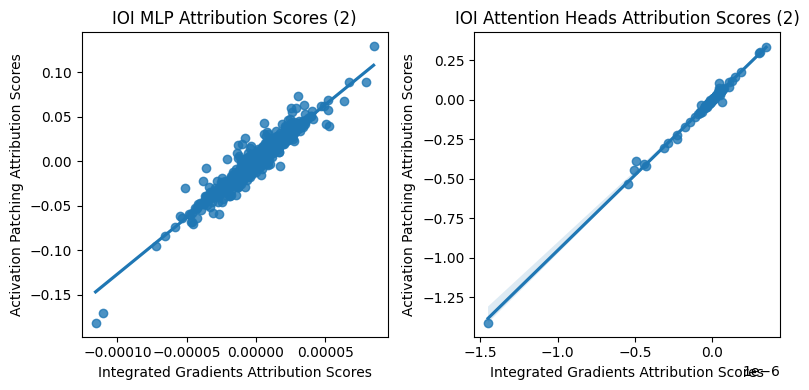

Correlation coefficient for neurons: 0.9757320311419594
Correlation coefficient for attention heads: 0.9967339352568454


In [11]:
print("Correlation between clean -> corrupt IG and AP")
plot_correlation_comparison(ig_clean_corrupt_mlp[:3], ap_clean_corrupt_mlp[:3], ig_clean_corrupt_attn[:3], ap_clean_corrupt_attn[:3], Task.IOI)

Correlation between corrupt -> clean IG and AP


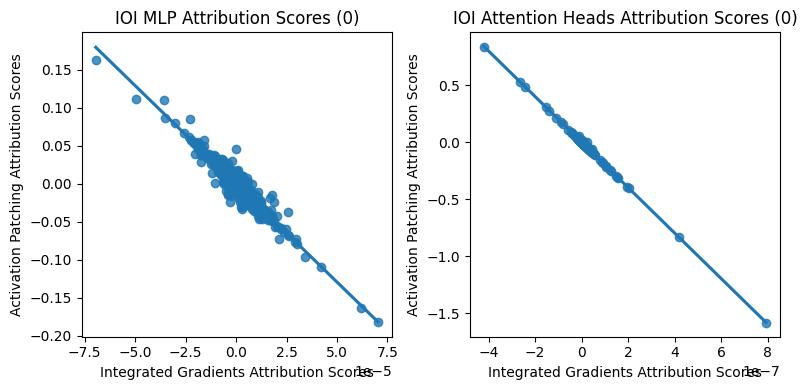

Correlation coefficient for neurons: -0.9813482434332876
Correlation coefficient for attention heads: -0.9994609854739294


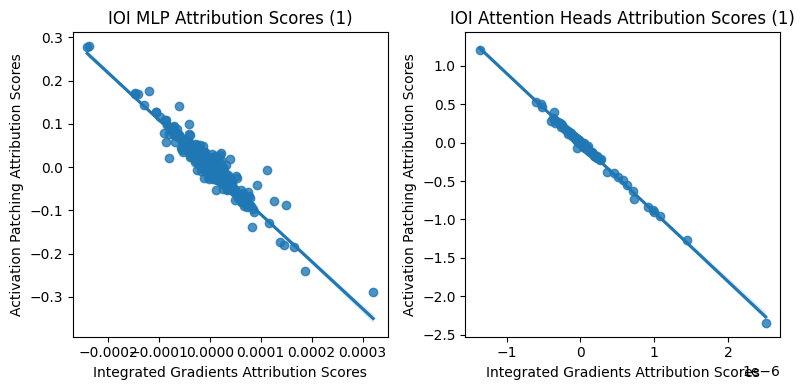

Correlation coefficient for neurons: -0.9675319208398431
Correlation coefficient for attention heads: -0.9980831403666831


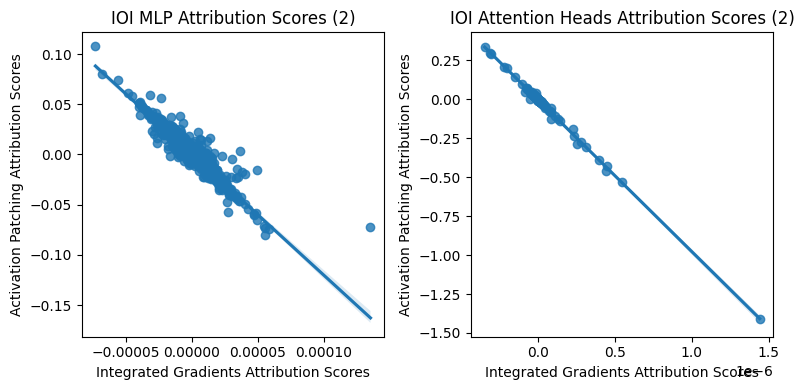

Correlation coefficient for neurons: -0.9675847810877175
Correlation coefficient for attention heads: -0.9983263095961261


In [12]:
print("Correlation between corrupt -> clean IG and AP")
plot_correlation_comparison(ig_corrupt_clean_mlp[:3], ap_corrupt_clean_mlp[:3], ig_corrupt_clean_attn[:3], ap_corrupt_clean_attn[:3], Task.IOI)

In [19]:
print(f"Average absolute correlation between clean->corrupt IG and AP (MLP): {average_correlation(ig_clean_corrupt_mlp, ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and AP (attention): {average_correlation(ig_clean_corrupt_attn, ap_clean_corrupt_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and AP (MLP): {average_correlation(ig_corrupt_clean_mlp, ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and AP (attention): {average_correlation(ig_corrupt_clean_attn, ap_corrupt_clean_attn)}")

Average absolute correlation between clean->corrupt IG and AP (MLP): 0.9589831382542942
Average absolute correlation between clean->corrupt IG and AP (attention): 0.9960553561898219
Average absolute correlation between corrupt->clean IG and AP (MLP): 0.9624919069894462
Average absolute correlation between corrupt->clean IG and AP (attention): 0.9961928809044427


To verify that clean -> corrupt and corrupt -> clean yield different results, we plot the correlation between IG and AP in non-corresponding directions.

In [20]:
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): {average_correlation(ig_clean_corrupt_mlp, ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): {average_correlation(ig_clean_corrupt_attn, ap_corrupt_clean_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): {average_correlation(ig_corrupt_clean_mlp, ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): {average_correlation(ig_corrupt_clean_attn, ap_clean_corrupt_attn)}")

Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): 0.5969981309104789
Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): 0.9543896958456307
Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): 0.5980245157318892
Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): 0.9536333408994208


Since the correlation is consistently lower between IG and AP in non-corresponding directions, this suggests that IG can approximate AP in the corresponding direction.

## Identifying latent components

We identify latent components as those with high attribution scores in clean->corrupt, but not in corrupt->clean (or vice versa). This is quantified using the asymmetry score, which is calculated as the difference between scores in opposite directions, normalised by maximum difference. A latent component should have an asymmetry score above one standard deviation (approximately 34%).

In [6]:
def asymmetry_score(corrupt_clean: Tensor, clean_corrupt: Tensor, is_ig: bool):
    assert corrupt_clean.shape == clean_corrupt.shape, \
        f"Cannot calculate asymmetry between matrices of different shapes, {corrupt_clean.shape} and {clean_corrupt.shape}"

    if is_ig:
        # Expect opposite directions to cancel out attribution scores
        max_scores = torch.amax((clean_corrupt + corrupt_clean), dim=(1,2), keepdim=True)
        return torch.div((corrupt_clean + clean_corrupt), max_scores)
    
    max_scores = torch.amax((corrupt_clean - clean_corrupt), dim=(1,2), keepdim=True)
    return torch.div((corrupt_clean - clean_corrupt), max_scores)

In [7]:
ig_mlp_asymmetry = asymmetry_score(ig_corrupt_clean_mlp, ig_clean_corrupt_mlp, is_ig=True)
ig_attn_asymmetry = asymmetry_score(ig_corrupt_clean_attn, ig_clean_corrupt_attn, is_ig=True)

ap_mlp_asymmetry = asymmetry_score(ap_corrupt_clean_mlp, ap_clean_corrupt_mlp, is_ig=False)
ap_attn_asymmetry = asymmetry_score(ap_corrupt_clean_attn, ap_clean_corrupt_attn, is_ig=False)

### Latent components identified by IG vs. AP

We evaluate the extent of overlap between latent components identified using IG, and latent components identified using AP. We expect this number to be high if IG can approxiamte AP latent components.

Overlap between latent attention heads identified by IG vs AP: 0.5343043208122253


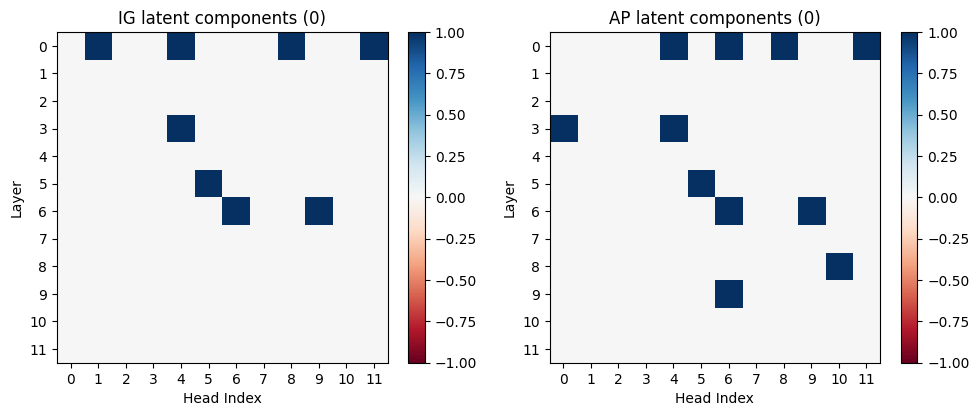

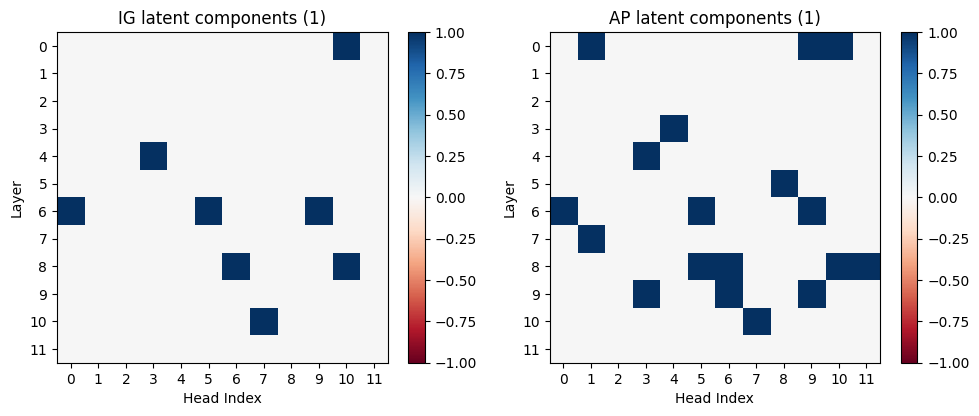

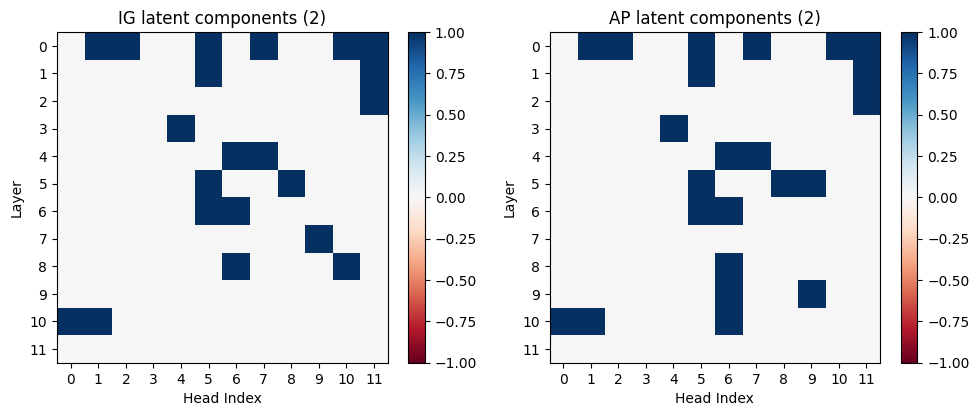

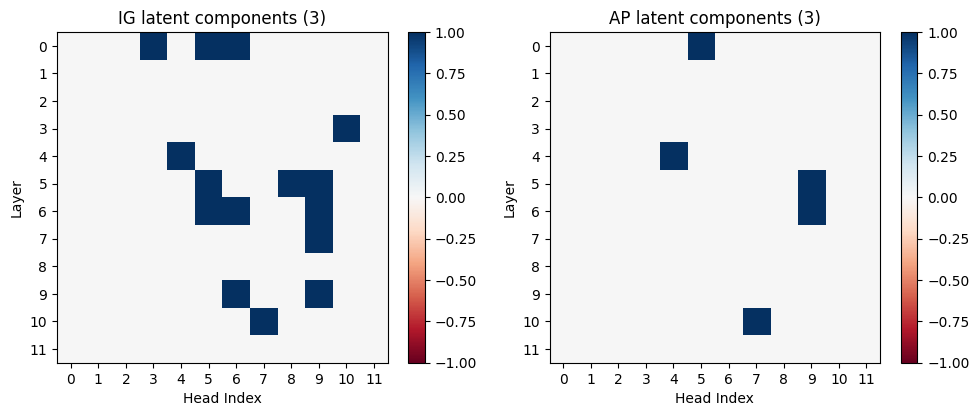

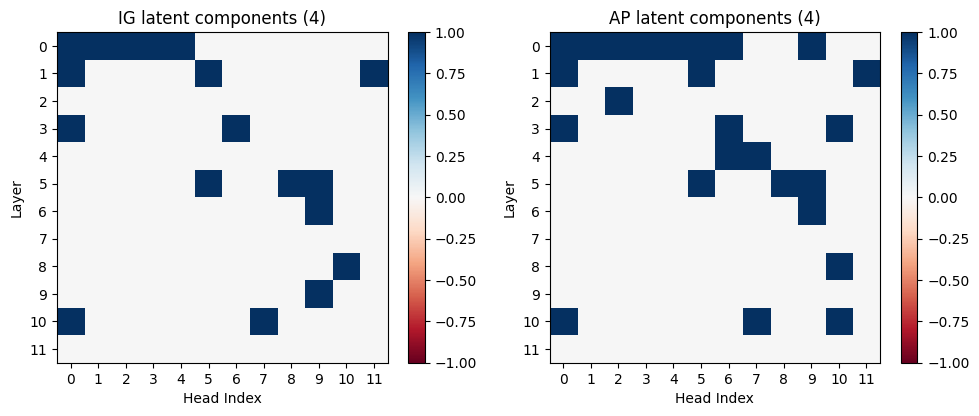

In [8]:
latent_attn_ig = ig_attn_asymmetry.abs() > 0.34
latent_attn_ap = ap_attn_asymmetry.abs() > 0.34

latent_attn_overlap = measure_overlap(latent_attn_ig, latent_attn_ap)
mean_latent_attn_overlap = latent_attn_overlap.mean()
print(f"Overlap between latent attention heads identified by IG vs AP: {mean_latent_attn_overlap}")

plot_attn_comparison(latent_attn_ig[:5].int(), latent_attn_ap[:5].int(), model, "IG latent components", "AP latent components")

In [9]:
latent_mlp_ig = ig_mlp_asymmetry.abs() > 0.34
latent_mlp_ap = ap_mlp_asymmetry.abs() > 0.34

latent_mlp_overlap = measure_overlap(latent_mlp_ig, latent_mlp_ap)
mean_latent_mlp_overlap = latent_mlp_overlap.mean()
print(f"Overlap between latent MLP neurons identified by IG vs AP: {mean_latent_mlp_overlap}")

Overlap between latent MLP neurons identified by IG vs AP: 0.48394569754600525


###  Comparison to discrepancies

Hypothesis: components which are highlighted exclusively by one attribution method are latent components.

To evaluate this, we measure the overlap between components highlighted exclusively by one method, and components highlighted as latent components.

In [47]:
ig_attn_significant, ig_attn_significant_indices = highlight_components(ig_clean_corrupt_attn)
ap_attn_significant, ap_attn_significant_indices = highlight_components(ap_clean_corrupt_attn)

ig_attn_exclusive = ig_attn_significant & ~ap_attn_significant
ap_attn_exclusive = ap_attn_significant & ~ig_attn_significant

ig_attn_exclusive_overlap = measure_overlap(ig_attn_exclusive, latent_attn_ig)
ap_attn_exclusive_overlap = measure_overlap(ap_attn_exclusive, latent_attn_ig)

print(f"Overlap between IG-exclusive attention heads and latent attention heads: {ig_attn_exclusive_overlap.mean()}")
print(f"Overlap between AP-exclusive attention heads and latent attention heads: {ap_attn_exclusive_overlap.mean()}")

Overlap between IG-exclusive attention heads and latent attention heads: 0.0325896292924881
Overlap between AP-exclusive attention heads and latent attention heads: 0.01809292659163475


In [48]:
ig_mlp_significant, ig_mlp_significant_indices = highlight_components(ig_clean_corrupt_mlp)
ap_mlp_significant, ap_mlp_significant_indices = highlight_components(ap_clean_corrupt_mlp)

ig_mlp_exclusive = ig_mlp_significant & ~ap_mlp_significant
ap_mlp_exclusive = ap_mlp_significant & ~ig_mlp_significant

ig_mlp_exclusive_overlap = measure_overlap(ig_mlp_exclusive, latent_mlp_ig)
ap_mlp_exclusive_overlap = measure_overlap(ap_mlp_exclusive, latent_mlp_ig)

print(f"Overlap between IG-exclusive MLP neurons and latent MLP neurons: {ig_mlp_exclusive_overlap.mean()}")
print(f"Overlap between AP-exclusive MLP neurons and latent MLP neurons: {ap_mlp_exclusive_overlap.mean()}")

Overlap between IG-exclusive MLP neurons and latent MLP neurons: 0.0014820274664089084
Overlap between AP-exclusive MLP neurons and latent MLP neurons: 0.0017955340445041656


## Ablating latent components

Hypothesis: components with high asymmetry between patching directions are latent components which significantly affect performance if ablated alongside other components.

- OR components are identified by patching from clean -> corrupt only.
- AND components are identified by patching from corrupt -> clean only.

To test this, we ablate latent components and evaluate model performance using average logit difference:

1. Ablate all OR components at once.
2. Ablate all AND components at once.
3. Ablate all IG-AP components (those highlighted by both IG and AP at once).
4. Ablate all OR components and IG-AP components.
5. Ablate all AND components and IG-AP components.
6. Ablate all components highlighted by IG.
7. Ablate all components highlighted by AP.

### Experiment

In [12]:
# Baseline performance
model.reset_hooks()

logits = model(clean_input)
baseline_performance = logit_diff_metric(logits, labels).mean()

print(f"Mean baseline performance: {baseline_performance}")

Mean baseline performance: 0.5738016366958618


In [13]:
# Ablate using mean corrupt activations
mean_corrupt_activations = dict()
for hook_name, act in corrupted_cache.cache_dict.items():
    mean_corrupt_activations[hook_name] = act.mean(dim=0)

In [ ]:
# AND components: corrupt->clean detects, clean->corrupt does not detect
and_ig_attn_indices = (ig_attn_asymmetry > 0.34).nonzero()
and_ap_attn_indices = (ap_attn_asymmetry > 0.34).nonzero()

and_ig_mlp_indices = (ig_mlp_asymmetry > 0.34).nonzero()
and_ap_mlp_indices = (ap_mlp_asymmetry > 0.34).nonzero()

# OR components: corrupt->clean does not detect, clean->corrupt detects
or_ig_attn_indices = (ig_attn_asymmetry < -0.34).nonzero()
or_ap_attn_indices = (ap_attn_asymmetry < -0.34).nonzero()

or_ig_mlp_indices = (ig_mlp_asymmetry < -0.34).nonzero()
or_ap_mlp_indices = (ap_mlp_asymmetry < -0.34).nonzero()

In [64]:
# Components highlighted by both
ig_attn_set_indices = set([tuple(x) for x in ig_attn_significant_indices.tolist()])
ap_attn_set_indices = set([tuple(x) for x in ap_attn_significant_indices.tolist()])

both_attn_indices = list(ig_attn_set_indices.intersection(ap_attn_set_indices))

ig_mlp_set_indices = set([tuple(x) for x in ig_mlp_significant_indices.tolist()])
ap_mlp_set_indices = set([tuple(x) for x in ap_mlp_significant_indices.tolist()])
both_mlp_indices = list(ig_mlp_set_indices.intersection(ap_mlp_set_indices))

In [ ]:
latent_ig_attn_ablation_scores = dict()
latent_ap_attn_ablation_scores = dict()

In [ ]:
# 1. Ablate all OR components at once.
latent_ig_attn_ablation_scores["OR"] = test_multi_ablated_performance(
    model, or_ig_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)
latent_ap_attn_ablation_scores["OR"] = test_multi_ablated_performance(
    model, or_ap_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

# 2. Ablate all AND components at once.
latent_ig_attn_ablation_scores["AND"] = test_multi_ablated_performance(
    model, and_ig_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)
latent_ap_attn_ablation_scores["AND"] = test_multi_ablated_performance(
    model, and_ap_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

Test IOI performance with 100 samples of ablated components
torch.Size([100, 21])
Mean performance: 0.5115442276000977
Test IOI performance with 100 samples of ablated components
torch.Size([100, 21])
Mean performance: 0.5318213701248169
Test IOI performance with 100 samples of ablated components
torch.Size([100, 21])
Mean performance: 0.5633341670036316
Test IOI performance with 100 samples of ablated components
torch.Size([100, 21])
Mean performance: 0.49235936999320984


In [69]:
# 3. Ablate all IG-AP components (those highlighted by both IG and AP at once).
both_attn_ablated_performance = test_multi_ablated_performance(
    model, both_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)
latent_ig_attn_ablation_scores["IG-AP"] = both_attn_ablated_performance
latent_ap_attn_ablation_scores["IG-AP"] = both_attn_ablated_performance

Test IOI performance with 100 samples of ablated components
Mean performance: 0.4880225956439972


In [71]:
# 4. Ablate all OR components and IG-AP components.
latent_ig_attn_ablation_scores["OR + IG-AP"] = test_multi_ablated_performance(
    model, or_ig_attn_indices.tolist() + both_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)
latent_ap_attn_ablation_scores["OR + IG-AP"] = test_multi_ablated_performance(
    model, or_ap_attn_indices.tolist() + both_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

# 5. Ablate all AND components and IG-AP components.
latent_ig_attn_ablation_scores["AND + IG-AP"] = test_multi_ablated_performance(
    model, and_ig_attn_indices.tolist() + both_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)
latent_ap_attn_ablation_scores["AND + IG-AP"] = test_multi_ablated_performance(
    model, and_ap_attn_indices.tolist() + both_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

Test IOI performance with 100 samples of ablated components
Mean performance: 0.48048973083496094
Test IOI performance with 100 samples of ablated components
Mean performance: 0.4811972677707672
Test IOI performance with 100 samples of ablated components
Mean performance: 0.4782058596611023
Test IOI performance with 100 samples of ablated components
Mean performance: 0.46893051266670227


In [72]:
# 6. Ablate all components highlighted by IG.
latent_ig_attn_ablation_scores["IG"] = test_multi_ablated_performance(
    model, ig_attn_significant_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

# 7. Ablate all components highlighted by AP.
latent_ap_attn_ablation_scores["AP"] = test_multi_ablated_performance(
    model, ap_attn_significant_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

Test IOI performance with 100 samples of ablated components
Mean performance: 0.518759548664093
Test IOI performance with 100 samples of ablated components
Mean performance: 0.5511701703071594


### Analysis

To evaluate the impact of latent components, we compare the model performances under ablation.

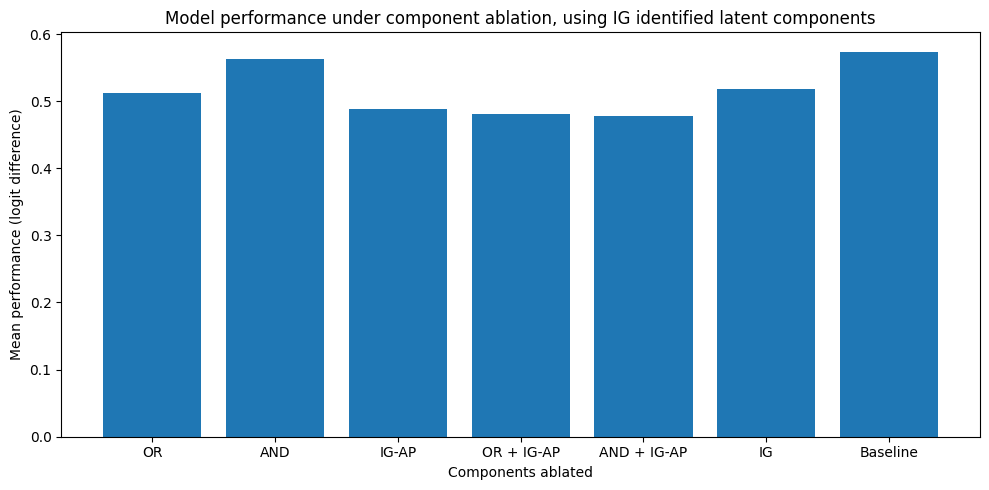

In [83]:
latent_ig_attn_ablation_scores["Baseline"] = baseline_performance

plot_bar_chart(
    latent_ig_attn_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under component ablation, using IG identified latent components")

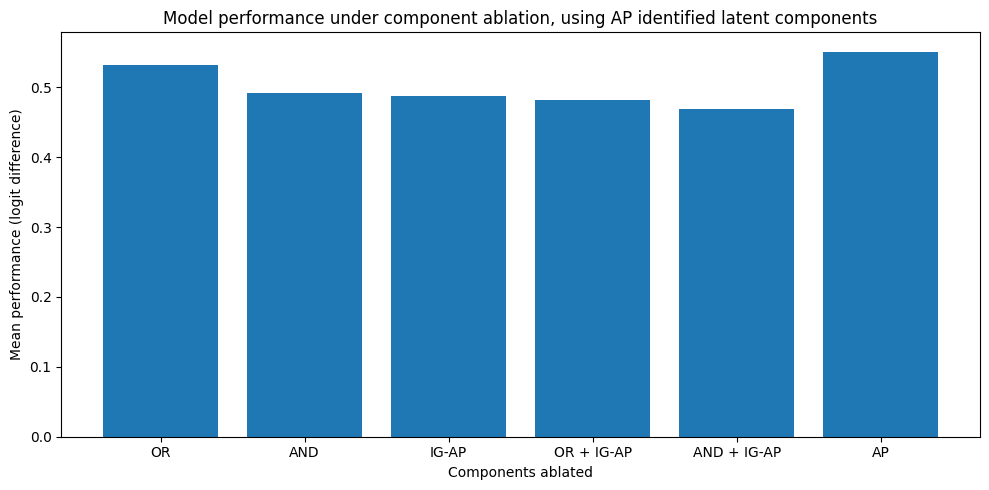

In [84]:
latent_ig_attn_ablation_scores["Baseline"] = baseline_performance

plot_bar_chart(
    latent_ap_attn_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under component ablation, using AP identified latent components")

## Generalisation

Hypothesis: IG can approximate AP in the corresponding direction for multiple tasks.

### Greater-Than

In [88]:
from testing import greater_than_prob_diff_metric

greater_than_dataset = TaskDataset(Task.GREATER_THAN)
greater_than_dataloader = greater_than_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(greater_than_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = greater_than_prob_diff_metric(model, clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = greater_than_prob_diff_metric(model, corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([ 0.8670,  0.8998,  0.9045,  0.8931,  0.8261,  0.8083,  0.9399,  0.8767,
         0.7247,  0.9015,  0.8210,  0.8544,  0.8492,  0.8596,  0.9377,  0.5882,
         0.8244,  0.8729,  0.9530,  0.8655,  0.9432,  0.9268,  0.8044,  0.8718,
         0.6772,  0.8514,  0.8844,  0.8216,  0.8870,  0.7221,  0.9517,  0.8526,
         0.8055,  0.8832,  0.7858,  0.4179,  0.9520,  0.8633,  0.8283,  0.9166,
         0.9020,  0.7755,  0.6411,  0.8366,  0.8993,  0.9411,  0.9138,  0.7848,
         0.8788,  0.8683,  0.4046,  0.8780,  0.9315,  0.8202,  0.8017,  0.8528,
         0.8538,  0.8295,  0.8560,  0.8585,  0.8935,  0.9062,  0.8381,  0.9049,
         0.0631,  0.9225, -0.1883,  0.9213,  0.8439,  0.8605,  0.3895,  0.9208,
         0.8139,  0.8789,  0.8855,  0.9023,  0.5799,  0.8774,  0.8771,  0.9171,
         0.8438, -0.0192,  0.8881,  0.9197,  0.8702,  0.6880,  0.8587,  0.9462,
         0.8470,  0.6209,  0.7185,  0.7852,  0.8294,  0.9640,  0.8169,  0.9211,
         0.9457,

In [90]:
from functools import partial

greater_than_metric = partial(greater_than_prob_diff_metric, model)

In [92]:
greater_than_ig_clean_corrupt_mlp, greater_than_ig_clean_corrupt_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, greater_than_metric, labels)

torch.save(greater_than_ig_clean_corrupt_mlp, "results/latent_components/greater_than/ig_clean_corrupt_mlp.pt")
torch.save(greater_than_ig_clean_corrupt_attn, "results/latent_components/greater_than/ig_clean_corrupt_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-7.0781e-08,  5.9605e-07, -6.7055e-08, -1.0207e-06,  1.3486e-06,
         1.6391e-07, -2.1607e-07, -1.0133e-06,  7.1526e-07,  7.9721e-07,
         2.4401e-06,  4.0978e-08, -7.9907e-07, -9.1642e-07, -5.7742e-07,
         3.1888e-06, -2.0117e-07, -6.7800e-07,  2.1048e-07,  6.2585e-07,
         4.3958e-07, -1.3039e-07, -9.5367e-07,  2.7753e-07, -1.6391e-06,
         0.0000e+00, -2.3805e-06,  5.8115e-07,  1.6764e-07, -9.5367e-07,
        -6.7055e-08,  1.4380e-06,  1.9632e-06, -2.9430e-07,  1.3262e-06,
         5.9903e-06, -5.2154e-08, -2.0489e-06,  3.4273e-07,  6.9663e-07,
        -4.4703e-07,  2.0862e-07,  1.9819e-06,  1.1176e-06, -1.7434e-06,
         3.2596e-08,  1.7881e-07, -3.2783e-07,  1.2666e-07,  2.3916e-06,
        -3.6955e-06,  8.8289e-07, -1.1176e-06,  9.8348e-07, -8.3447e-07,
         1.9297e-06, -2.1458e-06, -8.9407e-08,  1.3858e-06,  1.0729e-06,
         7.1526e-07, -6.2585e-07, -1.9744e-06, -1.0356e-06,  5.245

RuntimeError: could not compute gradients for some functions

In [ ]:
greater_than_ap_clean_corrupt_mlp, greater_than_ap_clean_corrupt_attn = activation_patching(model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, greater_than_metric, labels)

torch.save(greater_than_ap_clean_corrupt_mlp, "results/latent_components/greater_than/ap_clean_corrupt_mlp.pt")
torch.save(greater_than_ap_clean_corrupt_attn, "results/latent_components/greater_than/ap_clean_corrupt_attn.pt")

In [ ]:
greater_than_ig_corrupt_clean_mlp, greater_than_ig_corrupt_clean_attn = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, greater_than_metric, labels)

torch.save(greater_than_ig_corrupt_clean_mlp, "results/latent_components/greater_than/ig_corrupt_clean_mlp.pt")
torch.save(greater_than_ig_corrupt_clean_attn, "results/latent_components/greater_than/ig_corrupt_clean_attn.pt")

In [ ]:
greater_than_ap_corrupt_clean_mlp, greater_than_ap_corrupt_clean_attn = activation_patching(model, corrupted_tokens, corrupted_cache, corrupted_logit_diff, clean_cache, clean_logit_diff, greater_than_metric, labels)

torch.save(greater_than_ap_corrupt_clean_mlp, "results/latent_components/greater_than/ap_corrupt_clean_mlp.pt")
torch.save(greater_than_ap_corrupt_clean_attn, "results/latent_components/greater_than/ap_corrupt_clean_attn.pt")

In [ ]:
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): {average_correlation(greater_than_ig_clean_corrupt_mlp, greater_than_ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): {average_correlation(greater_than_ig_clean_corrupt_attn, greater_than_ap_corrupt_clean_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): {average_correlation(greater_than_ig_corrupt_clean_mlp, greater_than_ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): {average_correlation(greater_than_ig_corrupt_clean_attn, greater_than_ap_clean_corrupt_attn)}")

### Capital Country

In [93]:
capital_country_dataset = TaskDataset(Task.CAPITAL_COUNTRY)
capital_country_dataloader = capital_country_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(capital_country_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-1.8200e+00, -2.5300e+00, -2.0190e+00,  6.3455e+00, -5.2651e-01,
         9.5128e-01,  8.3471e-01, -1.4007e+00,  2.1496e+00, -3.0366e+00,
        -1.9888e+00, -2.4605e+00,  1.8581e+00, -2.1915e+00,  4.4449e-01,
        -2.5304e+00, -1.0142e+00, -4.1187e-01,  1.6885e+00,  7.7189e-01,
        -2.6999e+00, -2.8442e+00, -4.1971e+00,  9.2689e-01,  4.0291e+00,
        -2.2892e+00, -6.7081e-01,  1.0529e+00,  1.0367e+00, -8.7463e-01,
         3.9553e+00,  6.6132e-01,  8.6298e-02, -3.7175e+00, -2.3760e-01,
         3.5704e+00, -2.3199e+00,  1.8338e+00,  3.1291e+00, -1.4578e+00,
         1.1052e-03,  6.2353e+00,  1.2950e+00, -8.1945e-01,  2.0202e-01,
        -2.4481e+00, -4.8091e+00,  1.0870e+00,  7.8114e-01, -3.3017e-01,
         2.4613e+00,  1.4654e+00,  3.8742e-01,  2.1720e+00, -2.4098e-01,
        -1.7736e+00,  1.3818e+00,  4.6563e+00,  7.5080e-01,  1.9365e+00,
        -2.5477e+00, -8.0684e-01, -2.5662e+00, -4.0473e-01, -1.6847e+00,
         3.6113e-01,  1.270

In [ ]:
capital_country_ig_clean_corrupt_mlp, capital_country_ig_clean_corrupt_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(capital_country_ig_clean_corrupt_mlp, "results/latent_components/capital_country/ig_clean_corrupt_mlp.pt")
torch.save(capital_country_ig_clean_corrupt_attn, "results/latent_components/capital_country/ig_clean_corrupt_attn.pt")

In [97]:
capital_country_ap_clean_corrupt_mlp, capital_country_ap_clean_corrupt_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(capital_country_ap_clean_corrupt_mlp, "results/latent_components/capital_country/ap_clean_corrupt_mlp.pt")
torch.save(capital_country_ap_clean_corrupt_attn, "results/latent_components/capital_country/ap_clean_corrupt_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [98]:
capital_country_ig_corrupt_clean_mlp, capital_country_ig_corrupt_clean_attn = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, logit_diff_metric, labels)

torch.save(capital_country_ig_corrupt_clean_mlp, "results/latent_components/capital_country/ig_corrupt_clean_mlp.pt")
torch.save(capital_country_ig_corrupt_clean_attn, "results/latent_components/capital_country/ig_corrupt_clean_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-2.6785e-06,  3.7421e-06,  9.6112e-07,  3.2485e-06,  1.7434e-06,
        -2.4550e-06, -2.0862e-07, -2.1178e-06,  1.1129e-07, -1.7751e-06,
        -2.9635e-06, -2.3302e-06, -3.2131e-07, -6.4075e-07, -2.5611e-06,
        -1.8030e-06,  1.9837e-07,  1.4454e-06,  7.2829e-07, -1.0356e-06,
        -1.4119e-06, -5.7090e-07, -2.8387e-06,  3.6135e-06, -1.5438e-05,
        -6.1095e-07, -2.4959e-07,  7.7486e-07, -7.0874e-07, -7.5996e-07,
         1.4082e-06,  2.7418e-06, -5.1968e-07, -1.9222e-06, -9.9093e-07,
        -1.9930e-06, -2.3842e-07, -7.4506e-07, -7.7486e-07,  1.6540e-06,
        -1.8030e-06,  3.9488e-07, -4.7535e-06, -7.1526e-07, -3.1479e-06,
         1.7490e-06,  3.5502e-06, -2.6524e-06,  4.5002e-06, -3.6322e-07,
        -1.3448e-06,  1.4901e-06,  1.9297e-06,  7.6368e-07, -2.4214e-06,
        -1.1101e-06,  1.6503e-06, -4.0978e-07, -1.8962e-06,  5.7369e-07,
         1.5851e-06,  1.0394e-06,  4.4554e-06,  1.8179e-06, -1.740

In [ ]:
capital_country_ap_corrupt_clean_mlp, capital_country_ap_corrupt_clean_attn = activation_patching(model, corrupted_tokens, corrupted_logit_diff, clean_cache, clean_logit_diff, logit_diff_metric, labels)

torch.save(capital_country_ap_corrupt_clean_mlp, "results/latent_components/capital_country/ap_corrupt_clean_mlp.pt")
torch.save(capital_country_ap_corrupt_clean_attn, "results/latent_components/capital_country/ap_corrupt_clean_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1


In [ ]:
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): {average_correlation(capital_country_ig_clean_corrupt_mlp, capital_country_ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): {average_correlation(capital_country_ig_clean_corrupt_attn, capital_country_ap_corrupt_clean_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): {average_correlation(capital_country_ig_corrupt_clean_mlp, capital_country_ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): {average_correlation(capital_country_ig_corrupt_clean_attn, capital_country_ap_clean_corrupt_attn)}")

### Gender Bias

In [ ]:
gender_bias_dataset = TaskDataset(Task.GENDER_BIAS)
gender_bias_dataloader = gender_bias_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(gender_bias_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

In [ ]:
gender_bias_ig_clean_corrupt_mlp, gender_bias_ig_clean_corrupt_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(gender_bias_ig_clean_corrupt_mlp, "results/latent_components/gender_bias/ig_clean_corrupt_mlp.pt")
torch.save(gender_bias_ig_clean_corrupt_attn, "results/latent_components/gender_bias/ig_clean_corrupt_attn.pt")

In [ ]:
gender_bias_ap_clean_corrupt_mlp, gender_bias_ap_clean_corrupt_attn = activation_patching(model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(gender_bias_ap_clean_corrupt_mlp, "results/latent_components/gender_bias/ap_clean_corrupt_mlp.pt")
torch.save(gender_bias_ap_clean_corrupt_attn, "results/latent_components/gender_bias/ap_clean_corrupt_attn.pt")

In [ ]:
gender_bias_ig_corrupt_clean_mlp, gender_bias_ig_corrupt_clean_attn = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, logit_diff_metric, labels)

torch.save(gender_bias_ig_corrupt_clean_mlp, "results/latent_components/gender_bias/ig_corrupt_clean_mlp.pt")
torch.save(gender_bias_ig_corrupt_clean_attn, "results/latent_components/gender_bias/ig_corrupt_clean_attn.pt")

In [ ]:
gender_bias_ap_corrupt_clean_mlp, gender_bias_ap_corrupt_clean_attn = activation_patching(model, corrupted_tokens, corrupted_cache, corrupted_logit_diff, clean_cache, clean_logit_diff, logit_diff_metric, labels)

torch.save(gender_bias_ap_corrupt_clean_mlp, "results/latent_components/gender_bias/ap_corrupt_clean_mlp.pt")
torch.save(gender_bias_ap_corrupt_clean_attn, "results/latent_components/gender_bias/ap_corrupt_clean_attn.pt")

In [ ]:
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): {average_correlation(gender_bias_ig_clean_corrupt_mlp, gender_bias_ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): {average_correlation(gender_bias_ig_clean_corrupt_attn, gender_bias_ap_corrupt_clean_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): {average_correlation(gender_bias_ig_corrupt_clean_mlp, gender_bias_ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): {average_correlation(gender_bias_ig_corrupt_clean_attn, gender_bias_ap_clean_corrupt_attn)}")